The problem we are trying to solve imvolves determining the probability that the center 32x32px region of a patch contains at least one pixel of tumor tissue.

In [34]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tifffile import imread

import os
import shutil
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import tensorflow as tf
import tensorflow_io as tfio

['histopathologic-cancer-detection']


In [35]:
base_tile_dir = '../input/histopathologic-cancer-detection/train'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
df_data = df.merge(labels, on = "id")

# removing this image because it caused a training error previously
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df_data.head(3)


,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0


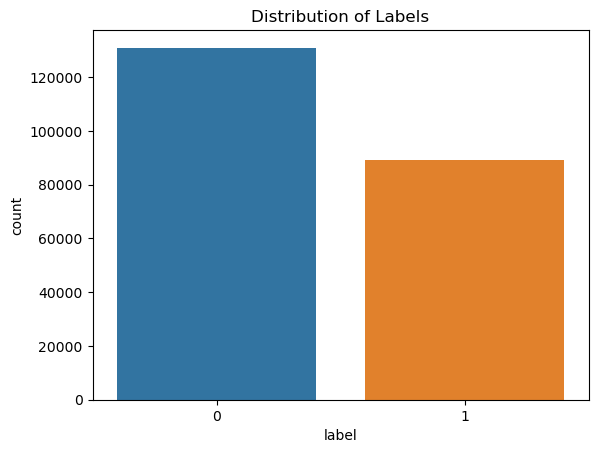

In [36]:
sns.countplot(x='label', data=df_data)
plt.title('Distribution of Labels')
plt.show()

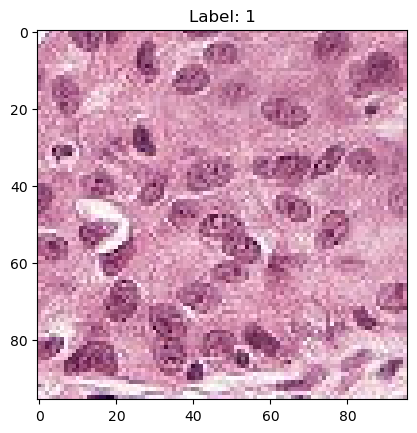

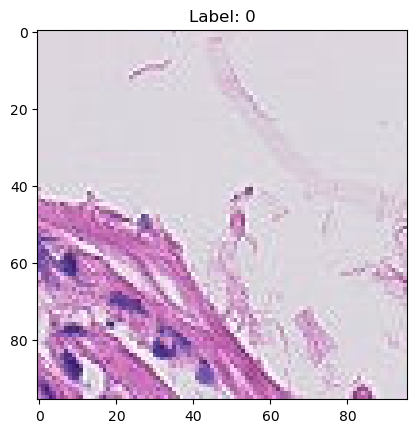

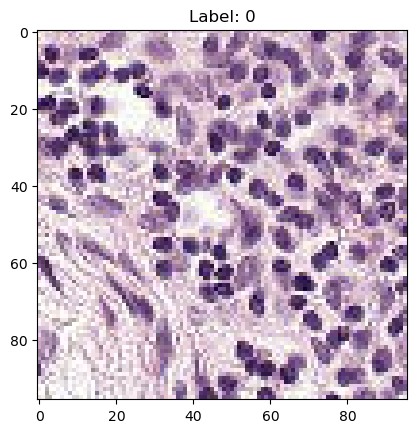

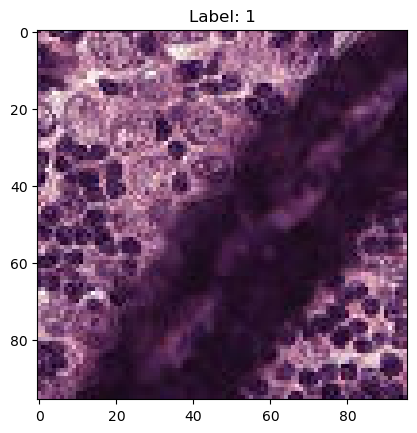

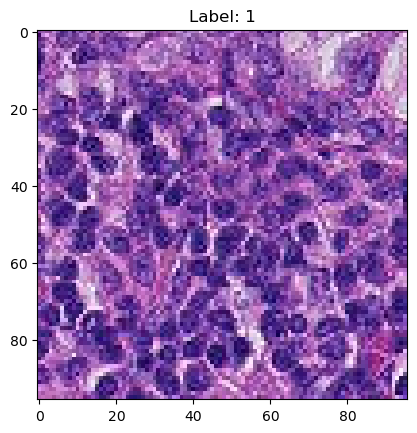

In [37]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'

# let's take first 5 images
sample_images = df_data['id'][:5].values

for img_id in sample_images:
    img = imread(train_path + img_id + '.tif')
    plt.imshow(img)
    plt.title('Label: ' + str(df_data[df_data['id'] == img_id]['label'].values[0]))
    plt.show()

The pictures are approximately 100x100 and RGB.  The ratio of no cancer to cancer is not too imbalanced.  Since we are interested in the center 32x32 of the pictures we would need to resize.  

In this case, the Convolutional Neural Network (CNN) is a natural choice for image classification tasks. CNNs can take in 3-dimensional tensors (RGB images) and work very well with local spatial coherence, which should help identify cancer in the central 32x32 region of the images.

The model's overall architecture could look like this:

Input Layer: Accepts an input shape of (100, 100, 3). This will take in the 100x100 pixel images with 3 color channels (RGB).

Convolutional Layers: Several convolutional layers (Conv2D in Keras) with increasing number of filters, typically starting with 32 or 64. Each convolutional layer is usually followed by a ReLU activation function to introduce nonlinearity.

Pooling Layers: After each few convolutional layers, a MaxPooling layer is usually used to downsample the input and reduce the spatial dimensions.

Dropout Layers: Some dropout layers might be used after the pooling layers to prevent overfitting.

Fully Connected Layers: After the last pooling layer, the data is flattened and then passed through a few fully connected (dense) layers with dropout layers in between. Again, ReLU activations are commonly used here.

Output Layer: The final dense layer has 1 neuron with a sigmoid activation function, which gives the model's prediction for the presence of cancer.


In [38]:
!pip install tensorflow-io --upgrade

import tensorflow as tf
import tensorflow_io as tfio

print(tf.__version__)
print(tfio.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 36.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0
  Attempting uninstall: tensorflow-io
    Found existing installation: tensorflow-io 0.31.0
    Uninstalling tensorflow-io-0.31.0:
      Successfully uninstalled tensorflow-io-0.31.0
2.12.0
0.31.0


In [39]:
SAMPLE_SIZE = 80000 # load 80k negative examples

# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = shuffle(pd.concat([df_0, df_1], axis=0).reset_index(drop=True))

# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/test'

for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf), exist_ok=True)

        

In [40]:
#print(df_data.columns)
df_data
#print(df_data.index)

,path,id,label
133972,../input/histopathologic-cancer-detection/trai...,c1e3be3c429825e77d3e632a0be932666e49b53a,1
79295,../input/histopathologic-cancer-detection/trai...,09eb72608bb2bce93e239f5b503cf095ec567487,0
119132,../input/histopathologic-cancer-detection/trai...,5bf2e8f3222fc9bb08acc033984d03a0b66eeadb,1
33033,../input/histopathologic-cancer-detection/trai...,94e1c829fddfea2f48dccfde11226032c1ce0771,0
159082,../input/histopathologic-cancer-detection/trai...,bdd03469cbdf7de65b12186e4974bd90789a11df,1
...,...,...,...
120140,../input/histopathologic-cancer-detection/trai...,407a984b015c58c7c977ac392978b584059d35ae,1
18690,../input/histopathologic-cancer-detection/trai...,87446d3acb05459667184ea7ad9ecf9ba80e3adb,0
105893,../input/histopathologic-cancer-detection/trai...,c3a46fc402525e031672896382a744d2dee08b79,1
149242,../input/histopathologic-cancer-detection/trai...,47b553a73500b8a26417402fe7debef4a25c939a,1


In [41]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,path,label
id,,
c1e3be3c429825e77d3e632a0be932666e49b53a,../input/histopathologic-cancer-detection/trai...,1
09eb72608bb2bce93e239f5b503cf095ec567487,../input/histopathologic-cancer-detection/trai...,0
5bf2e8f3222fc9bb08acc033984d03a0b66eeadb,../input/histopathologic-cancer-detection/trai...,1
94e1c829fddfea2f48dccfde11226032c1ce0771,../input/histopathologic-cancer-detection/trai...,0
bdd03469cbdf7de65b12186e4974bd90789a11df,../input/histopathologic-cancer-detection/trai...,1


In [42]:
!ls ./base_dir/train/




0  1


In [43]:
for image in df_train['id'].values:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)  # Adjusted line
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val['id'].values:
    fname = image + '.tif'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/histopathologic-cancer-detection/train', fname)  # Adjusted line
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)
    
    

In [44]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 96
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [46]:

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps)

scores = model.evaluate(test_gen)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10


2023-07-10 21:48:58.148652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4500/4500 [==============================] - 589s 130ms/step - loss: 0.4150 - accuracy: 0.8152 - val_loss: 0.3235 - val_accuracy: 0.8597
Epoch 2/10
4500/4500 [==============================] - 538s 120ms/step - loss: 0.3163 - accuracy: 0.8680 - val_loss: 0.2929 - val_accuracy: 0.8739
Epoch 3/10
4500/4500 [==============================] - 537s 119ms/step - loss: 0.2921 - accuracy: 0.8801 - val_loss: 0.2536 - val_accuracy: 0.8981
Epoch 4/10
4500/4500 [==============================] - 532s 118ms/step - loss: 0.2794 - accuracy: 0.8848 - val_loss: 0.2641 - val_accuracy: 0.8949
Epoch 5/10
4500/4500 [==============================] - 534s 119ms/step - loss: 0.2700 - accuracy: 0.8913 - val_loss: 0.3113 - val_accuracy: 0.8856
Epoch 6/10
4500/4500 [==============================] - 538s 120ms/step - loss: 0.2677 - accuracy: 0.8916 - val_loss: 0.2355 - val_accuracy: 0.9104
Epoch 7/10
4500/4500 [==============================] - 577s 128ms/step - loss: 0.2612 - accuracy: 0.8952 - val_loss: 0.243

/tmp/ipykernel_28/2954576193.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


16000/16000 [==============================] - 71s 4ms/step


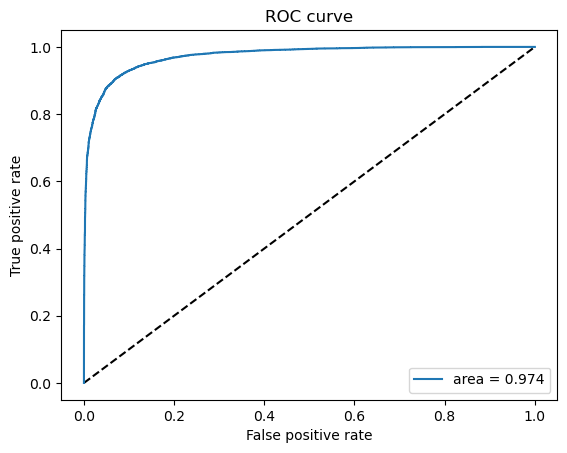

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
base_test_dir = '../input/histopathologic-cancer-detection/test'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

Indexes: 0 - 5000
157/157 [==============================] - 1s 4ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 1s 4ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 1s 4ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 1s 3ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 1s 4ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 1s 4ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 1s 4ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 1s 4ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 1s 4ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 1s 4ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 1s 5ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 0s 4ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.598812
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.001441
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.068677
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.325042
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.297963


In [51]:
shutil.rmtree(train_path)
shutil.rmtree(valid_path)
submission.to_csv("submission.csv", index = False, header = True)
pd.read_csv("submission.csv")

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.598812
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.001441
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.068677
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.325042
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.297963
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0.000521
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0.184368
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0.739024
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0.283516
